<a href="https://colab.research.google.com/github/nantmoe-theingi/airbnb-nz-deception-sentiment/blob/main/notebooks/04_data_preprocessing_pipeline_airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: DATA INTAKE & SCHEMA AUDIT
import pandas as pd
import numpy as np

REVIEWS_CSV  = "data/airbnb_nz_reviews.csv"
LISTINGS_CSV = "data/airbnb_nz_listings.csv"

# 1) Load the dataset both as strings
reviews  = pd.read_csv(REVIEWS_CSV, dtype=str, low_memory=False)
listings = pd.read_csv(LISTINGS_CSV, dtype=str, low_memory=False)

print("Loaded.")
print("reviews shape:", reviews.shape)
print("listings shape:", listings.shape)

Loaded.
reviews shape: (2951093, 6)
listings shape: (46645, 85)


In [ ]:
# 2) Show column sets
print("\nreviews columns:", list(reviews.columns))
print("\nlistings columns:", list(listings.columns))


reviews columns: ['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments']

listings columns: ['id', 'listing_url', 'scrape_id', 'last_searched', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability'

In [ ]:
# 3) Basic integrity checks on key columns
must_have_reviews = ["listing_id","id","date","comments"]
missing_cols_r = [c for c in must_have_reviews if c not in reviews.columns]
print("\nMissing essential review columns:", missing_cols_r)

must_have_listings = ["id","listing_url","price","property_type","room_type"]
missing_cols_l = [c for c in must_have_listings if c not in listings.columns]
print("Missing essential listing columns:", missing_cols_l)


Missing essential review columns: []
Missing essential listing columns: []


In [ ]:
# 4) Quick data quality snapshots
# reviews
r_nonempty_text = reviews["comments"].notna().sum() if "comments" in reviews else np.nan
r_min_date = pd.to_datetime(reviews["date"], errors="coerce", dayfirst=True).min()
r_max_date = pd.to_datetime(reviews["date"], errors="coerce", dayfirst=True).max()
r_unique_listings = reviews["listing_id"].nunique() if "listing_id" in reviews else np.nan

print("\n--- Reviews snapshot ---")
print("Total reviews:", len(reviews))
print("Reviews with non-empty 'comments':", r_nonempty_text)
print("Unique listings referenced:", r_unique_listings)
print("Date range:", r_min_date, "to", r_max_date)

# listings
l_unique_ids = listings["id"].nunique() if "id" in listings else np.nan
print("\n--- Listings snapshot ---")
print("Total listings:", len(listings))
print("Unique listing ids:", l_unique_ids)


--- Reviews snapshot ---
Total reviews: 2951093
Reviews with non-empty 'comments': 2950839
Unique listings referenced: 41597
Date range: 2011-03-05 00:00:00 to 2025-12-07 00:00:00

--- Listings snapshot ---
Total listings: 46645
Unique listing ids: 46645


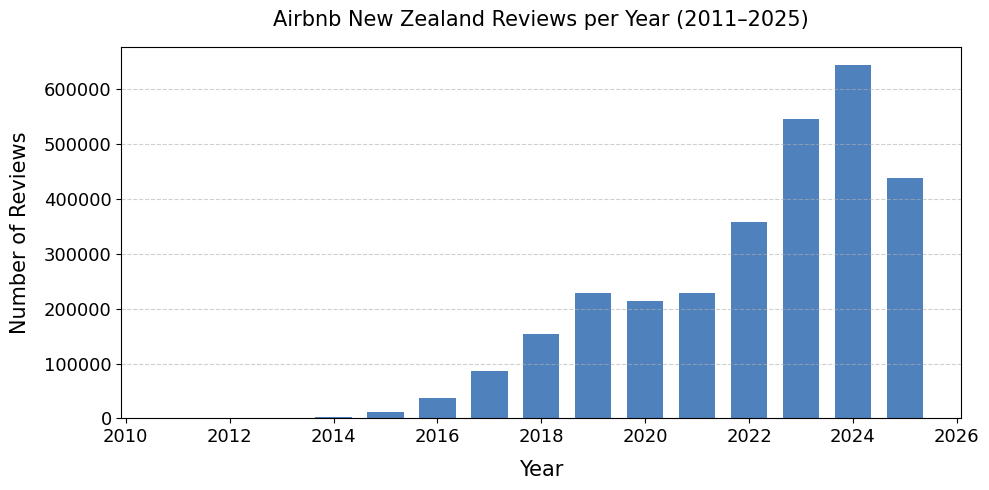

In [ ]:
import matplotlib.pyplot as plt

reviews['date'] = pd.to_datetime(reviews['date'], errors='coerce')
reviews['year'] = reviews['date'].dt.year

# --- Count reviews per year ---
year_counts = reviews['year'].value_counts().sort_index()

# --- Plot configuration ---
plt.figure(figsize=(10, 5))
plt.bar(year_counts.index, year_counts.values, color="#4F81BD", width=0.7)

# --- Labels and formatting ---
plt.xlabel("Year", fontsize=15, labelpad=10)
plt.ylabel("Number of Reviews", fontsize=15, labelpad=10)
plt.title("Airbnb New Zealand Reviews per Year (2011–2025)", fontsize=15, pad=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# --- Tight layout and save as PNG ---
plt.tight_layout()
plt.savefig("figures/review_date_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# 5) Null rates on a few critical fields
def null_rate(s):
    return float(s.isna().mean()*100)

summary_nulls = {}
for col in ["listing_id","id","date","comments","reviewer_id","reviewer_name"]:
    if col in reviews:
        summary_nulls[f"reviews.{col}"] = round(null_rate(reviews[col]), 2)
for col in ["id","price","property_type","room_type","latitude","longitude",
            "host_is_superhost","host_acceptance_rate","host_response_rate","amenities"]:
    if col in listings:
        summary_nulls[f"listings.{col}"] = round(null_rate(listings[col]), 2)

print("\n--- Null percentage (selected columns) ---")
for k,v in summary_nulls.items():
    print(f"{k}: {v}%")


--- Null percentage (selected columns) ---
reviews.listing_id: 0.0%
reviews.id: 0.0%
reviews.date: 0.0%
reviews.comments: 0.01%
reviews.reviewer_id: 0.0%
reviews.reviewer_name: 0.0%
listings.id: 0.0%
listings.price: 4.29%
listings.property_type: 0.0%
listings.room_type: 0.0%
listings.latitude: 0.0%
listings.longitude: 0.0%
listings.host_is_superhost: 2.04%
listings.host_acceptance_rate: 5.7%
listings.host_response_rate: 14.98%
listings.amenities: 0.0%


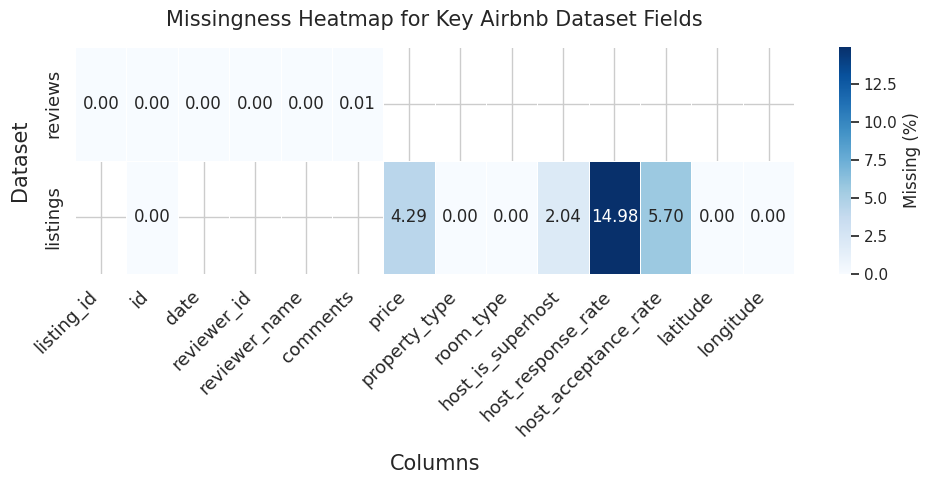

In [ ]:
import seaborn as sns

review_cols = ["listing_id", "id", "date", "reviewer_id", "reviewer_name", "comments"]
listing_cols = ["id", "price", "property_type", "room_type", "host_is_superhost",
                "host_response_rate", "host_acceptance_rate", "latitude", "longitude"]

# Compute missingness (True = missing)
reviews_missing = reviews[review_cols].isna()
listings_missing = listings[listing_cols].isna()

# Combine for visualization
# Stack both review and listing columns vertically for a comparative view
combined_missing = pd.concat(
    [reviews_missing.mean().rename("reviews"), listings_missing.mean().rename("listings")],
    axis=1
) * 100  # convert to percentage

# --- Set up the figure ---
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")

# --- Create a heatmap ---
ax = sns.heatmap(combined_missing.T, annot=True, fmt=".2f", cmap="Blues",
                 cbar_kws={'label': 'Missing (%)'}, linewidths=0.5)

# --- Formatting ---
plt.title("Missingness Heatmap for Key Airbnb Dataset Fields", fontsize=15, pad=15)
plt.xlabel("Columns", fontsize=15, labelpad=10)
plt.ylabel("Dataset", fontsize=15, labelpad=10)
plt.xticks(rotation=45, ha="right", fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

# --- Save the figure ---
plt.savefig("figures/missingness_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# 6) Preview a few rows that can cause issues
print("\nreviews.head():")
print(reviews.head(5).to_string(index=False)[:1200])
print("\nlistings.head():")
print(listings.head(5).to_string(index=False)[:1200])


reviews.head():
listing_id        id       date reviewer_id reviewer_name                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     comments
     46071 506601469 2019-08-10   124689447          Mari                                                                                                                                                                                                                                                                                                                                                       

In [ ]:
# 7) Check for duplicates
dup_reviews = reviews['id'].duplicated().sum()
dup_listings = listings['id'].duplicated().sum()

print(f"Duplicate review IDs: {dup_reviews} ({dup_reviews / len(reviews) * 100:.4f}%)")
print(f"Duplicate listing IDs: {dup_listings} ({dup_listings / len(listings) * 100:.4f}%)")

Duplicate review IDs: 0 (0.0000%)
Duplicate listing IDs: 0 (0.0000%)


In [ ]:
# 8) Cross-reference consistency
linked_ratio = reviews['listing_id'].isin(listings['id']).mean() * 100
print(f"Listing–review linkage consistency: {linked_ratio:.2f}%")

Listing–review linkage consistency: 100.00%


In [ ]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 42

sample = reviews['comments'].dropna().sample(500, random_state=42)
non_english = sum(detect(c) != 'en' for c in sample)
print(f"Non-English rate (sampled): {non_english / len(sample) * 100:.2f}%")

Non-English rate (sampled): 5.20%


In [ ]:
# 10) Schema validation
required_reviews_cols = ["listing_id", "id", "date", "reviewer_id", "reviewer_name", "comments"]
required_listings_cols = ["id", "price", "property_type", "room_type", "host_is_superhost", "neighbourhood", "region_name", "region_parent_name", "region_parent_parent_name" ]

missing_reviews = [c for c in required_reviews_cols if c not in reviews.columns]
missing_listings = [c for c in required_listings_cols if c not in listings.columns]

print("Missing in reviews:", missing_reviews)
print("Missing in listings:", missing_listings)

# 11) Select key columns for analysis
reviews_df = reviews[required_reviews_cols].copy()
listings_df = listings[required_listings_cols].copy()

print("Reviews columns selected:", list(reviews_df.columns))
print("Listings columns selected:", list(listings_df.columns))

Missing in reviews: []
Missing in listings: []
Reviews columns selected: ['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments']
Listings columns selected: ['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments']


In [ ]:
# STEP 2: DATA CLEANING & FILTERING (with full English filtering)
import pandas as pd
import re
from langdetect import detect, DetectorFactory

DetectorFactory.seed = 42  # ensure reproducibility

# Helper functions
def normalize_whitespace(s):
    """Trim, collapse whitespace, and remove zero-width chars."""
    zws = r'[\u200B-\u200D\uFEFF]'
    s = s.astype(str).str.replace(zws, '', regex=True)
    return s.str.replace(r'\s+', ' ', regex=True).str.strip()

print("STEP 2: DATA CLEANING & FILTERING")

# Normalize key columns
for c in ["listing_id","id","date","reviewer_id","reviewer_name","comments"]:
    reviews_df[c] = normalize_whitespace(reviews_df[c])
print("Normalized whitespace and removed control characters from key columns.")

# Drop rows with missing essential fields
essential = ["listing_id","id","date","comments"]
before = len(reviews_df)
missing_mask = reviews_df[essential].isna().any(axis=1) | (reviews_df[essential] == "").any(axis=1)
removed_missing = missing_mask.sum()
reviews_df = reviews_df.loc[~missing_mask].copy()
print(f"[Missing Values] Removed {removed_missing:,} rows → {len(reviews_df):,} remain.")

# Remove duplicate review IDs
dup_count = reviews_df["id"].duplicated(keep="first").sum()
reviews_df = reviews_df.drop_duplicates(subset=["id"], keep="first").copy()
print(f"[Duplicates] Removed {dup_count:,} duplicate review IDs → {len(reviews_df):,} remain.")

STEP 2: DATA CLEANING & FILTERING
Normalized whitespace and removed control characters from key columns.
[Missing Values] Removed 0 rows → 2,951,093 remain.
[Duplicates] Removed 0 duplicate review IDs → 2,951,093 remain.


In [ ]:
def is_symbol_only(text):
    """Return True if text has no alphabetic characters (only emojis/symbols)."""
    if not isinstance(text, str) or text.strip() == "":
        return True
    # Use a regex pattern compatible with Python's re module
    return not bool(re.search(r'[^\W\d_]', text))

# Remove blank / symbol-only comments
symbol_only_mask = reviews_df["comments"].apply(is_symbol_only)
removed_symbols = symbol_only_mask.sum()
reviews_df = reviews_df.loc[~symbol_only_mask].copy()
print(f"[Symbol-only Comments] Removed {removed_symbols:,} rows → {len(reviews_df):,} remain.")

[Symbol-only Comments] Removed 5,794 rows → 2,945,299 remain.


In [ ]:
# Detect and remove non-English reviews
import math
import numpy as np
from tqdm import tqdm
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 42

def detect_language_safe(text):
    try:
        lang = detect(text)
        return lang if lang else "other"
    except Exception:
        return "other"

def detect_language_in_chunk(df_chunk):
    return df_chunk["comments"].apply(detect_language_safe)

# configure chunking
N = len(reviews_df)
chunksize = 200_000
num_chunks = math.ceil(N / chunksize)

langs = []
print(f"Running language detection in {num_chunks} chunk(s) of ~{chunksize:,} rows...")

for i in tqdm(range(num_chunks), desc="Chunks"):
    start = i * chunksize
    stop  = min((i + 1) * chunksize, N)
    chunk = reviews_df.iloc[start:stop].copy()
    langs.append(detect_language_in_chunk(chunk))

# concatenate detected languages
reviews_df["lang"] = pd.concat(langs, axis=0).reset_index(drop=True)

# sanity check alignment
assert len(reviews_df["lang"]) == len(reviews_df), "Length mismatch after chunking!"

# distribution + filter
lang_pct = reviews_df["lang"].value_counts(normalize=True).mul(100).round(2)
print("Language distribution (%):")
print(lang_pct.to_string())

non_en_removed = (reviews_df["lang"] != "en").sum()
reviews_df = reviews_df.loc[reviews_df["lang"] == "en"].drop(columns=["lang"]).copy()
print(f"[Language Filter] Removed {non_en_removed:,} non-English reviews → {len(reviews_df):,} remain.")

Running language detection in 15 chunk(s) of ~200,000 rows...


Chunks: 100%|██████████| 15/15 [2:38:38<00:00, 634.58s/it]


Language distribution (%):
lang
en       93.11
zh-cn     1.78
de        1.25
fr        1.14
ko        0.59
ro        0.32
nl        0.24
af        0.21
es        0.19
zh-tw     0.16
so        0.15
ja        0.13
it        0.09
ca        0.08
tl        0.07
cs        0.06
pl        0.05
no        0.04
da        0.04
pt        0.04
sv        0.03
hu        0.03
cy        0.03
sw        0.02
id        0.02
hr        0.02
tr        0.01
vi        0.01
fi        0.01
et        0.01
he        0.01
ru        0.01
sl        0.01
sk        0.01
th        0.01
lv        0.00
lt        0.00
ar        0.00
sq        0.00
other     0.00
el        0.00
uk        0.00
bg        0.00
fa        0.00
[Language Filter] Removed 208,316 non-English reviews → 2,736,983 remain.


In [ ]:
lang_summary_path = "figures/language_distribution_summary.csv"
lang_pct.to_csv(lang_summary_path, header=["Percentage"])
print(f"[Saved] Language distribution summary saved to: {lang_summary_path}")

[Saved] Language distribution summary saved to: figures/language_distribution_summary.csv


In [ ]:
# Remove duplicate comments
dup_comments = reviews_df["comments"].duplicated(keep="first").sum()
reviews_df_step2_comments = reviews_df.drop_duplicates(subset=["comments"], keep="first").copy()
print(f"[Duplicate Comments] Removed {dup_comments:,} identical comment texts → {len(reviews_df_step2_comments):,} remain.")

[Duplicate Comments] Removed 98,589 identical comment texts → 2,638,394 remain.


In [ ]:
required_listings_cols = ["id", "price", "property_type", "room_type", "host_is_superhost", "neighbourhood", "region_name", "region_parent_name", "region_parent_parent_name" ]

missing_listings = [c for c in required_listings_cols if c not in listings.columns]

print("Missing in listings:", missing_listings)

listings_df = listings[required_listings_cols].copy()

print("Listings columns selected:", list(listings_df.columns))

print(f"Final English-only reviews: {len(reviews_df_step2_comments):,}")
print(f"Final listings: {len(listings_df):,}")

Missing in listings: []
Listings columns selected: ['id', 'price', 'property_type', 'room_type', 'host_is_superhost', 'neighbourhood', 'region_name', 'region_parent_name', 'region_parent_parent_name']
Final English-only reviews: 2,638,394
Final listings: 46,645


In [ ]:
# DATE FILTERING (Last 3 Years)
from datetime import datetime, timedelta

# Convert 'date' to datetime and remove invalid ones
reviews_df_step2_comments["date"] = pd.to_datetime(reviews_df_step2_comments["date"], errors="coerce")
invalid_dates = reviews_df_step2_comments["date"].isna().sum()
reviews_df_step2_date = reviews_df_step2_comments.dropna(subset=["date"]).copy()
print(f"[Invalid Dates] Removed {invalid_dates:,} rows with invalid date → {len(reviews_df_step2_date):,} remain.")

# Keep only reviews from the past 3 years up to today
today = pd.Timestamp.today().normalize()
three_years_ago = today - pd.DateOffset(years=3)

out_of_range = (reviews_df_step2_date["date"] < three_years_ago).sum()
reviews_df_step2_date = reviews_df_step2_date.loc[reviews_df_step2_date["date"] >= three_years_ago].copy()
print(f"[Date Filter] Removed {out_of_range:,} reviews older than {three_years_ago.date()} → {len(reviews_df_step2_date):,} remain.")

# sort by date (newest first)
reviews_df_step2_date = reviews_df_step2_date.sort_values("date", ascending=False).reset_index(drop=True)


[Invalid Dates] Removed 0 rows with invalid date → 2,638,394 remain.
[Date Filter] Removed 1,104,972 reviews older than 2022-10-17 → 1,533,422 remain.


In [ ]:
print(f"Final Step 2 reviews: {len(reviews_df_step2_date):,}")
print(f"Final listings: {len(listings_df):,}")

Final Step 2 reviews: 1,533,422
Final listings: 46,645


In [ ]:
import re
import os
import math
import numpy as np
import pandas as pd
from datetime import datetime

# Step 3: TEXT NORMALIZATION
# Lowercase, strip punctuation & digits, remove stopwords, lemmatize
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")
try:
    nltk.data.find("corpora/wordnet")
except LookupError:
    nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def normalize_text(text: str) -> str:
    """Lowercase → remove punctuation/digits → stopword removal → lemmatize."""
    if not isinstance(text, str):
        return ""
    # 1) lowercase
    text = text.lower()
    # 2) keep letters and spaces only
    text = re.sub(r"[^a-z\s]", " ", text)
    # 3) tokenize (simple whitespace split)
    tokens = text.split()
    # 4) remove stopwords & short tokens
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    # 5) lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    # 6) rejoin
    return " ".join(tokens)

# Apply normalization to the reviews
assert {"id","listing_id","date","comments"}.issubset(reviews_df_step2_date.columns), \
    "reviews  must have id, listing_id, date, comments"

print("Normalizing review comments → reviews_df_step2_date['text']...")
reviews_df_step3 = reviews_df_step2_date.copy()
reviews_df_step3["text"] = reviews_df_step3["comments"].apply(normalize_text)

Normalizing review comments → reviews_df_step2_date['text']...


In [ ]:
print(f"Final Step 3 reviews: {len(reviews_df_step3):,}")

Final Step 3 reviews: 1,533,422


In [ ]:
# Step 4: DATA INTEGRATION & STORAGE FORMAT
import re
import numpy as np
import pandas as pd

# Helpers
def clean_price(x):
    """Strip currency symbols, commas, spaces; keep digits and decimal."""
    if pd.isna(x):
        return np.nan
    s = str(x)
    s = re.sub(r"[^\d.,]", "", s)        # remove currency and other chars
    s = s.replace(",", "")               # drop thousands sep
    return pd.to_numeric(s, errors="coerce")

def _norm_text(s):
    if not isinstance(s, str):
        return np.nan
    s = re.sub(r"\s+", " ", s.strip())
    # Title case but keep ALL-CAPS acronyms
    return s.title()

# Required listing columns
sel_listing_cols = [
    "id", "price", "property_type", "room_type", "host_is_superhost",
    "neighbourhood", "region_name", "region_parent_name", "region_parent_parent_name"
]
missing_lst = [c for c in sel_listing_cols if c not in listings_df.columns]
if missing_lst:
    raise ValueError(f"listings_df missing required columns: {missing_lst}")

listings_work = listings_df[sel_listing_cols].copy()

# Normalize text-ish fields and clean price
for c in ["neighbourhood", "region_name", "region_parent_name", "region_parent_parent_name"]:
    listings_work[c] = listings_work[c].map(_norm_text)
listings_work["price_num"] = listings_work["price"].map(clean_price)

# Prefer region_parent_name (region), else region_name (city/area), else neighbourhood
listings_work["region"] = (
    listings_work["region_parent_name"]
    .fillna(listings_work["region_name"])
    .fillna(listings_work["neighbourhood"])
)

# Finalize listings schema
listings_work = listings_work.rename(columns={"id": "listing_id"})[
    ["listing_id", "price_num", "property_type", "room_type", "host_is_superhost",
     "neighbourhood", "region_name", "region_parent_name", "region_parent_parent_name", "region"]
].copy()

# Keep minimal review schema + normalized text
reviews_min = reviews_df_step3[["id", "listing_id", "date", "text"]].copy()
reviews_min = reviews_min.rename(columns={"id": "review_id"})

# Merge
merged = reviews_min.merge(listings_work, on="listing_id", how="left")

# Types & ordering
merged["review_id"]  = merged["review_id"].astype(str)
merged["listing_id"] = merged["listing_id"].astype(str)
merged["date"] = pd.to_datetime(merged["date"], errors="coerce", utc=True).dt.tz_convert(None)
merged = merged.dropna(subset=["date"]).sort_values(["listing_id", "date"]).reset_index(drop=True)

# Derive time keys
merged["year"]  = merged["date"].dt.year.astype("int16")
merged["month"] = merged["date"].dt.month.astype("int8")

# Save to Parquet
FINAL_PARQUET = "data/airbnb_reviews_cleaned.parquet"
merged.to_parquet(FINAL_PARQUET, index=False, compression="snappy")
print(f"[Saved] Analysis-ready Parquet → {FINAL_PARQUET}")
print("Final schema:", list(merged.columns))
print(merged.dtypes)

[Saved] Analysis-ready Parquet → data/airbnb_reviews_cleaned.parquet
Final schema: ['review_id', 'listing_id', 'date', 'text', 'price_num', 'property_type', 'room_type', 'host_is_superhost', 'neighbourhood', 'region_name', 'region_parent_name', 'region_parent_parent_name', 'region', 'year', 'month']
review_id                            object
listing_id                           object
date                         datetime64[ns]
text                                 object
price_num                           float64
property_type                        object
room_type                            object
host_is_superhost                    object
neighbourhood                        object
region_name                          object
region_parent_name                   object
region_parent_parent_name           float64
region                               object
year                                  int16
month                                  int8
dtype: object


In [ ]:
# STEP 5: OUTCOME OF PREPROCESSING
# Summarize the final Airbnb dataset after full cleaning and integration.

# basic structure
n_reviews   = len(merged)
n_listings  = merged["listing_id"].nunique()
n_regions   = merged["region"].nunique(dropna=True)
n_superhosts = merged["host_is_superhost"].nunique()
region_cov  = merged["region"].notna().mean() * 100

# Temporal coverage
date_min = merged["date"].min().date()
date_max = merged["date"].max().date()
year_span = merged["year"].nunique()

# ]Listing-level attributes summary
mean_price = merged["price_num"].mean()
median_price = merged["price_num"].median()

# Summary table
summary = {
    "Total reviews (final)": f"{n_reviews:,}",
    "Unique listings": f"{n_listings:,}",
    "Distinct regions": f"{n_regions:,}",
    "Region coverage (non-null)": f"{region_cov:.2f}%",
    "Date range": f"{date_min} → {date_max}",
    "Year span": f"{year_span} years",
    "Mean price (NZD)": f"{mean_price:,.2f}",
    "Median price (NZD)": f"{median_price:,.2f}"
}

summary_df = pd.DataFrame(list(summary.items()), columns=["Metric", "Value"])

print("\n=== OUTCOME OF PREPROCESSING ===")
print(summary_df.to_string(index=False))

# Save summary table for appendix
summary_path = "figures/preprocessing_outcome_summary.csv"
summary_df.to_csv(summary_path, index=False, encoding="utf-8")
print(f"\n[Saved] Outcome summary → {summary_path}")


=== OUTCOME OF PREPROCESSING ===
                    Metric                   Value
     Total reviews (final)               1,533,422
           Unique listings                  39,017
          Distinct regions                      67
Region coverage (non-null)                 100.00%
                Date range 2022-10-17 → 2025-08-06
                 Year span                 4 years
          Mean price (NZD)                  205.51
        Median price (NZD)                  150.00

[Saved] Outcome summary → figures/preprocessing_outcome_summary.csv


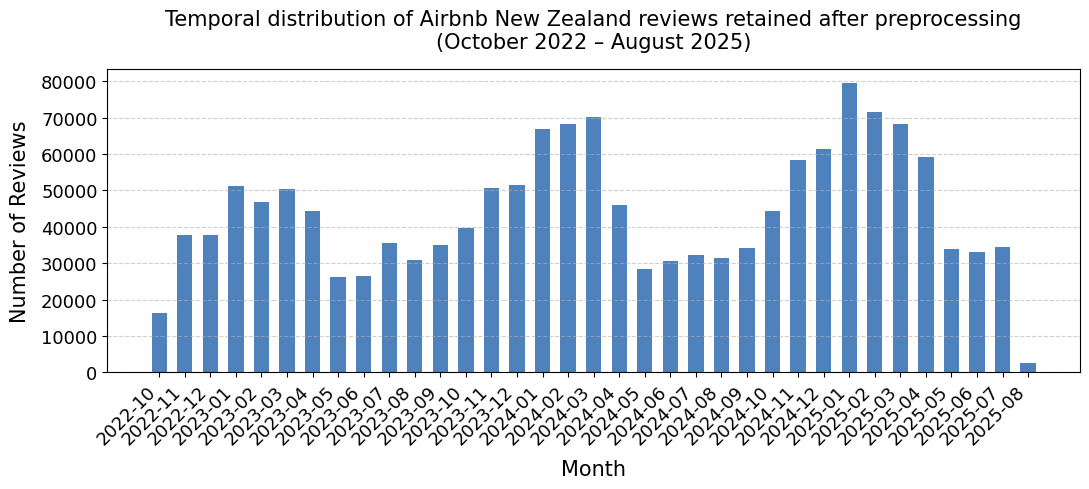

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_parquet("data/airbnb_reviews_cleaned.parquet")

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df[(df['date'] >= "2022-10-01") & (df['date'] <= "2025-08-31")]

# --- Aggregate monthly review counts ---
df['year_month'] = df['date'].dt.to_period('M').astype(str)
monthly_counts = df['year_month'].value_counts().sort_index()

# --- Plot configuration ---
plt.figure(figsize=(11, 5))
plt.bar(monthly_counts.index, monthly_counts.values, color="#4F81BD", width=0.6)

# --- Labels, ticks, and title ---
plt.title("Temporal distribution of Airbnb New Zealand reviews retained after preprocessing\n(October 2022 – August 2025)", fontsize=15, pad=15)
plt.xlabel("Month", fontsize=15, labelpad=8)
plt.ylabel("Number of Reviews", fontsize=15, labelpad=8)
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# --- Tight layout and export as high-resolution PNG ---
plt.tight_layout()
plt.savefig("figures/airbnb_review_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

                        region  review_count
1                     Auckland        208552
35   Queenstown-Lakes District        187011
7            Christchurch City        112846
47              Taupo District         67491
37            Rotorua District         60327
59             Wellington City         53388
25          Mackenzie District         51257
48               Tauranga City         49291
43          Southland District         40716
49  Thames-Coromandel District         40462
10          Far North District         40174
9                 Dunedin City         39418
52            Waikato District         31802
46             Tasman District         28131
14               Hamilton City         27222


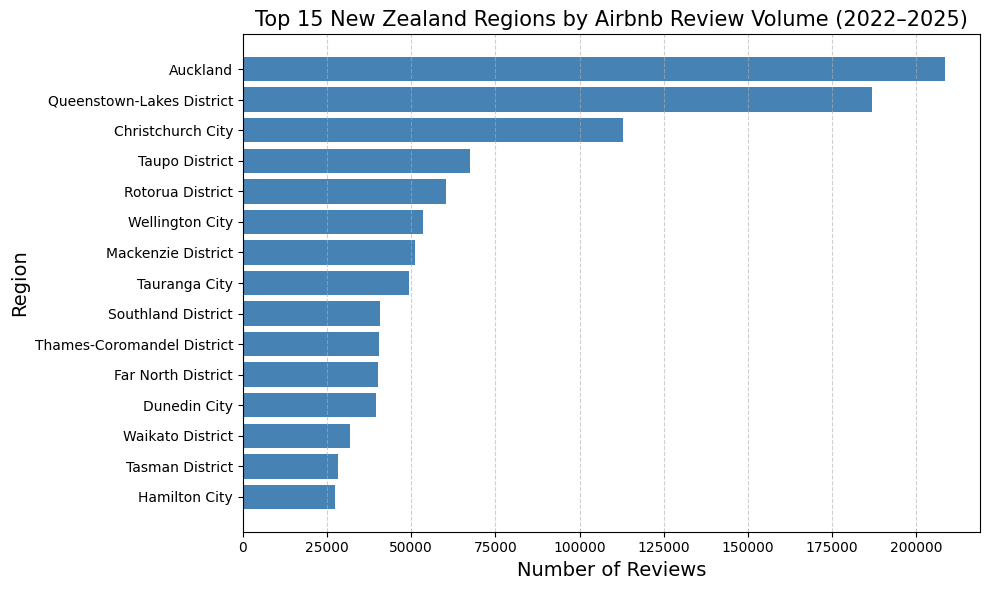

In [ ]:
# REGIONAL REVIEW DISTRIBUTION SUMMARY

import pandas as pd
import matplotlib.pyplot as plt

merged = pd.read_parquet("data/airbnb_reviews_cleaned.parquet")

# 1. Aggregate review counts by region
region_counts = (
    merged.groupby("region")["review_id"]
    .count()
    .reset_index()
    .rename(columns={"review_id": "review_count"})
    .sort_values("review_count", ascending=False)
)

# 2. Display top 15 regions
print(region_counts.head(15))

# 3. Save regional summary table for Appendix
region_counts.to_csv("figures/regional_review_distribution.csv", index=False, encoding="utf-8")

# 4. Plot top 15 regions for visualization
plt.figure(figsize=(10, 6))
plt.barh(region_counts.head(15)["region"], region_counts.head(15)["review_count"], color="steelblue")
plt.xlabel("Number of Reviews", fontsize=14)
plt.ylabel("Region", fontsize=14)
plt.title("Top 15 New Zealand Regions by Airbnb Review Volume (2022–2025)", fontsize=15)
plt.gca().invert_yaxis()  # largest on top
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()

# 5. Save figure
plt.savefig("figures/regional_review_distribution.png", dpi=300)
plt.show()
